In [1]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('input_data.xlsx')
df.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,45015.0,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0


Мы взяли готовый датасет "Russia Real Estate 2021" с kaggle. Эти данные отображают информацию о рынке недвижимости в России в 2021 году. Данный выбор обусловлен интересом к анализу цен на квартиры в Москве, датасет актуален, изначально содержит 15 переменных. 

In [3]:
print(f'Исходная размерность таблицы:{df.shape}')

Исходная размерность таблицы:(1048575, 15)


Видно, что строчек в таблице очень много, поэтому было посчитано количество данных на каждый регион. Кроме того, мы понимаем, что нельзя построить одну модель, описывающую рынок жилья во всей России.

In [4]:
df['id_region'].value_counts()

77    100454
50     83628
23     80729
78     70069
72     58471
       ...  
4        169
6         54
87        16
79         5
83         2
Name: id_region, Length: 86, dtype: int64

Видно, что больше всего данных приходится на 77 регион (Москва), поэтому было принято решение анализировать жилищный рынок Москвы.

In [5]:
df_1 = df[df['id_region'] == 77]
df_1

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007.0,580339.0,77,2069062.0
36,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432.0,451495.0,77,1430362.0
38,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226.0,201942.0,77,1251884.0
140,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020.0,394412.0,77,2183736.0
150,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165.0,152778.0,77,2173638.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405.0,459781.0,77,2686656.0
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620.0,320194.0,77,2495941.0
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427.0,495809.0,77,2370839.0
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674.0,147782.0,77,2615851.0


Перед тем, как перейти к предобраотке данных, опишем переменные:
- __date__ - дата публикации объявления о продаже
- __price__ - цена в рублях, указанная в объявлении
- __level__ - этаж, на котором расположена квартира
- __levels__ - количество этажей в доме
- __rooms__ - число жилых комнат (если -1, то это квартира-студия)
- __area__ - полная площадь квартиры
- __kitchen_area__ - площадь кухни
- __geo_lat__ - географическая широта
- __geo_lon__ - географическая долгота
- __building_type__ - качественная переменная, обозначающая материал дома. Расшифровка: 0 - неизвестно, 1 - другой, 2 - панельный дом, 3 - монолитный дом, 4 - кирпич, 5 - блочный, 6 - дерево
- __object_type__ - качественная переменная, обозначающая тип апартаментов. Расшифровка: 0 - вторичное жилье, 2 - первичное жилье
- __postal_code__ - почтовый индекс
- __street_id__ - ID улицы
- __id_region__ - код региона
- __house_id__ - ID дома

Уже при выгрузке данных было видно, что в столбцах street_id и house_id были пропуски, кроме того, на сайте не было должного описания этих переменных. Поэтому мы приняли решение удалить их из таблицы. Удалили также столбец id_region, так как знаем, что это Москва.

In [6]:
df_new = df_1.drop(['street_id', 'house_id', 'id_region'], axis=1)
df_new

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007.0
36,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432.0
38,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226.0
140,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020.0
150,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405.0
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620.0
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427.0
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674.0


Далее мы хотим добавить новый признак - удаленность квартиры от центра Москвы. Центр будем отсчитывать от Красной Площади, зададим ее географические координаты:

In [7]:
msk_center_lat = 55.753514
msk_center_lon = 37.621202

In [8]:
#  ищем разницу координат Красной Площади и каждой квартиры
df_new['diff_lat'] = abs(df_new['geo_lat'] - msk_center_lat)
df_new['diff_lon'] = abs(df_new['geo_lon'] - msk_center_lon)
df_new

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007.0,0.024512,0.081055
36,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432.0,0.050720,0.044951
38,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226.0,0.081444,0.016176
140,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020.0,0.012843,0.091666
150,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165.0,0.013350,0.074208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405.0,0.163537,0.020006
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620.0,0.107109,0.210816
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427.0,0.072403,0.023024
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674.0,0.054597,0.313684


Конечно, удобнее смотреть разницу в километрах, а не в градусах. Поэтому мы нашли, сколько километров содержится в одном градусе и перевели расстояние в новые единицы измерения.

In [9]:
df_new['diff_lat'] = df_new['diff_lat']*111.134861111
df_new['diff_lon'] = df_new['diff_lon']*111.134861111
df_new

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007.0,2.724138,9.008036
36,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432.0,5.636760,4.995623
38,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226.0,9.051312,1.797695
140,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020.0,1.427305,10.187288
150,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165.0,1.483595,8.247074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405.0,18.174662,2.223364
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620.0,11.903510,23.429051
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427.0,8.046497,2.558769
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674.0,6.067630,34.861239


Разница в широте и долготе не дает сделать качетсвенный вывод об удаленности от центра. Вспоминаем, что меридианы и параллели перпендикулярны друг другу и находим расстояние от квартиры до центра по формуле: 
$$S = \sqrt{{(x_b - x_a)^2 + (y_b - y_a)^2}}$$

где $$(x_b - x_a)^2$$ - квадрат разницы долготы, $$(y_b - y_a)^2$$ - квадрат разницы широты.

In [10]:
df_new['gap'] = np.sqrt(df_new['diff_lat']**2 + df_new['diff_lon']**2)
df_new

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007.0,2.724138,9.008036,9.410932
36,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432.0,5.636760,4.995623,7.531887
38,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226.0,9.051312,1.797695,9.228107
140,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020.0,1.427305,10.187288,10.286790
150,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165.0,1.483595,8.247074,8.379456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405.0,18.174662,2.223364,18.310152
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620.0,11.903510,23.429051,26.279536
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427.0,8.046497,2.558769,8.443543
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674.0,6.067630,34.861239,35.385338


Есть две переменные со схожим названием, из-за чего может возникнуть путаница, поэтому level мы переименовали в floor, а levels - в n_floors.

In [11]:
df_new.rename(columns = {'level':'floor', 'levels':'n_floors'}, inplace = True )
df_new

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap
10,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007.0,2.724138,9.008036,9.410932
36,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432.0,5.636760,4.995623,7.531887
38,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226.0,9.051312,1.797695,9.228107
140,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020.0,1.427305,10.187288,10.286790
150,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165.0,1.483595,8.247074,8.379456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048521,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405.0,18.174662,2.223364,18.310152
1048530,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620.0,11.903510,23.429051,26.279536
1048536,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427.0,8.046497,2.558769,8.443543
1048550,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674.0,6.067630,34.861239,35.385338


Таблица выглядит неопрятно с  индексами не по порядку, поэтому проведем  переиндексацию:

In [12]:
df_new.reset_index(drop=True, inplace=True)
df_new

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007.0,2.724138,9.008036,9.410932
1,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432.0,5.636760,4.995623,7.531887
2,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226.0,9.051312,1.797695,9.228107
3,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020.0,1.427305,10.187288,10.286790
4,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165.0,1.483595,8.247074,8.379456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100449,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405.0,18.174662,2.223364,18.310152
100450,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620.0,11.903510,23.429051,26.279536
100451,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427.0,8.046497,2.558769,8.443543
100452,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674.0,6.067630,34.861239,35.385338


Для дальнейшей работы очень важно знать, сколько пропусков содержат данные.

In [13]:
df_new.isnull().sum()

date                 0
price                0
floor                0
n_floors             0
rooms                0
area                 0
kitchen_area         0
geo_lat              0
geo_lon              0
building_type        0
object_type          0
postal_code      15129
diff_lat             0
diff_lon             0
gap                  0
dtype: int64

Видно, что ни в одной переменной нет пропусков, кроме почтового индекса. Так как мы в дальнейшем хотим работать со значениями данной переменной, удалим все строчки, содержащие пропуски в почтовом индексе.

In [14]:
df_2 = df_new.dropna()

Переведем значение почтового индекса в целое число.

In [15]:
df_2['postal_code'] = df_2['postal_code'].astype(int)
df_2

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007,2.724138,9.008036,9.410932
1,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432,5.636760,4.995623,7.531887
2,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226,9.051312,1.797695,9.228107
3,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020,1.427305,10.187288,10.286790
4,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165,1.483595,8.247074,8.379456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100449,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405,18.174662,2.223364,18.310152
100450,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620,11.903510,23.429051,26.279536
100451,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427,8.046497,2.558769,8.443543
100452,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674,6.067630,34.861239,35.385338


In [16]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85325 entries, 0 to 100453
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           85325 non-null  datetime64[ns]
 1   price          85325 non-null  int64         
 2   floor          85325 non-null  int64         
 3   n_floors       85325 non-null  int64         
 4   rooms          85325 non-null  int64         
 5   area           85325 non-null  float64       
 6   kitchen_area   85325 non-null  float64       
 7   geo_lat        85325 non-null  float64       
 8   geo_lon        85325 non-null  float64       
 9   building_type  85325 non-null  int64         
 10  object_type    85325 non-null  int64         
 11  postal_code    85325 non-null  int32         
 12  diff_lat       85325 non-null  float64       
 13  diff_lon       85325 non-null  float64       
 14  gap            85325 non-null  float64       
dtypes: datetime64[ns](

Создадим переменные, содержащие индексы округов Москвы. 
Источник: http://www.mapofmoscow.ru/indexy.html

In [18]:
central = [121069, 121099,103062, 103064, 103070, 103084, 103097, 103132, 103175, 103289, 107005, 107066, 107078, 107082, 107120, 107262, 109210,103134, 109017, 109072, 109180, 113035, 113054, 113093, 113177, 113184, 113324, 113326, 117049,117325,103012,103045, 103450, 107139, 107140, 107174, 107217, 107228, 107245,103031, 129010, 129090, 129110, 129272,103001, 103025, 103104, 103274, 103379, 121002, 121019, 121205, 123022, 123056, 123100, 123242, 123286, 123290, 123317, 123557, 123610,103006, 103009, 103030, 103032, 103050, 103051, 103055, 103159, 103473, 121059, 125047, 125267,103006, 103009, 103030, 103032, 103050, 103051, 103055, 103159, 103473, 121059, 125047, 125267,119021, 119034, 119048, 119121, 119146, 119270, 119435, 121200]
north = [125083, 125167, 125190, 125315, 125319,123007, 125040, 125124, 125137, 125284,	127247, 127411, 127486, 127644,127599,127474, 127540, 127591,125413, 125438, 125493, 125499, 125565,103031, 125206, 125422, 127434, 127550, 117133,127412,125008, 125183, 125239, 125299,125195, 125445, 125475,127238125239, 125299, 125130, 125171, 125212,125057, 125080, 125252,103220, 103287, 125015, 127018,125413, 125414, 125475, 125502, 125581,123007, 125284, 125468, 123103]
north_east = [129272, 129164, 129278, 129301, 129366, 129626,127410,129281, 129344,	127349, 127543, 127549, 127560,103055, 125047, 103220, 127254, 127322,127253, 127572, 127576,129327, 129336, 129345, 129346,127106, 127276, 127427,129594,129075, 129085, 129515,127273, 127490, 127562, 127566,129128, 129223, 129226, 129256,129323, 129329, 129343,129224, 129282,125195, 127490, 127566, 127204,127018, 127521,129081, 129221, 129642,107140, 129164, 129337, 129338, 129347, 129348]
east = [107150, 107370, 107564, 111395, 111402, 111538, 111539, 109456, 105077, 105203, 107143, 107241, 107497, 107589, 111531, 111555, 111578,105037, 105043, 105173, 105264, 105554, 111621, 111622, 111625, 111672,111394, 111396, 111399, 111558,107258,111123, 111141, 111397, 111398, 111401, 111524,105122, 105215, 105425, 105484, 105523, 107065, 107207,105058, 105118, 105187, 105275, 105318, 105679,107014, 107076, 107113,105023, 107061, 107392, 107553,105568]
south = [113546, 115372, 115404, 115492, 115547, 115598,113403,115408, 115612,113556, 113638, 113639, 115230,113162, 113191, 117419,117071,113105, 113152,	115573, 115580, 115682, 115583,115304, 115477, 115516, 115541,115409, 115446, 115478, 115522,115487, 115533,115142, 115407, 115470,115551, 115569,115561, 115582, 115583, 115597,113054, 113177, 113114,109044, 109316, 109280, 109428, 109088,113587, 113648,113208, 113519, 113525, 113570,113405, 113534, 113535, 113545]
south_east = [109444, 109472, 109507, 109542,109145,109429, 109649,109117, 109378, 109439, 109443, 109462,105275, 105094, 105229, 109033, 111020, 111024, 111116, 111250,109382, 109386, 109559,129594, 127018, 127521, 109369, 109651, 109652,109052, 109391,109235, 109383, 109388, 109548,109377, 109428, 109456, 109457,109125, 109129, 109263, 109387, 109390, 109518,109088, 109193, 109432]
south_west = [117036, 117218, 117292, 117449,103027,121002, 121019, 119034, 117296, 117333, 117334,113149, 113209, 113303, 113452, 113461,117279, 117342, 117437, 117647,113186, 113447,117296, 117119, 117261, 117311, 117331, 117330, 117192,113042, 113628,117133, 117321, 117465,117036, 117218, 117449, 113447, 117261, 117246, 117335, 117418, 117420,113623,117463, 117574, 117588, 117593]
west = [121087, 121096, 121309, 121601,117334, 117330, 119136, 119285, 119590,121151, 121165, 121170, 121248, 121293,121500, 121609, 121614, 121552,121351, 121356, 121359, 121467, 121552, 121374,119501, 119517,121059, 121151, 121165, 121291, 121353, 121354, 121374, 121471, 121596,117602,119530,117192, 117607,117297, 119332, 119618, 119619, 119620, 119633,117526, 117571,117296, 117333, 117330, 117454, 117415, 117606,121019, 121087, 121108, 121352, 121358, 121433]
north_west = [123627,123362, 123367, 123182,123373, 123459, 123480, 123481,123458, 123631, 123154,123103, 123154, 123308, 123423, 123585,123060, 123098, 123182, 123298, 123479,123363, 123364, 123371]

In [19]:
df_2['district'] = np.zeros(85325)
df_2.reset_index(drop=True, inplace=True)
df_2

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007,2.724138,9.008036,9.410932,0.0
1,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432,5.636760,4.995623,7.531887,0.0
2,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226,9.051312,1.797695,9.228107,0.0
3,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020,1.427305,10.187288,10.286790,0.0
4,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165,1.483595,8.247074,8.379456,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85320,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405,18.174662,2.223364,18.310152,0.0
85321,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620,11.903510,23.429051,26.279536,0.0
85322,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427,8.046497,2.558769,8.443543,0.0
85323,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674,6.067630,34.861239,35.385338,0.0


In [20]:
for i in range(85325):
    if df_2['postal_code'][i] in central:
        df_2['district'][i] = 'ЦАО'
    elif df_2['postal_code'][i] in north:
        df_2['district'][i] = 'САО'
    elif df_2['postal_code'][i] in north_east:
         df_2['district'][i] = 'СВАО'
    elif df_2['postal_code'][i] in east:
        df_2['district'][i] = 'ВАО'
    elif df_2['postal_code'][i] in south:
        df_2['district'][i] = 'ЮАО'
    elif df_2['postal_code'][i] in south_east:
        df_2['district'][i] = 'ЮВАО'
    elif df_2['postal_code'][i] in south_west:
        df_2['district'][i] = 'ЮЗАО'
    elif df_2['postal_code'][i] in west:
        df_2['district'][i] = 'ЗАО'
    elif df_2['postal_code'][i] in north_west:
        df_2['district'][i] = 'СЗАО'
    else:
        df_2['district'][i] = '-'
df_2

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007,2.724138,9.008036,9.410932,САО
1,2021-01-01,30000000,11,22,3,109.0,45061.0,55.702794,37.666153,3,0,115432,5.636760,4.995623,7.531887,-
2,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226,9.051312,1.797695,9.228107,СВАО
3,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020,1.427305,10.187288,10.286790,ЮВАО
4,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165,1.483595,8.247074,8.379456,ЗАО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85320,2021-02-15,20500000,10,25,3,82.0,45160.0,55.589977,37.601196,0,0,117405,18.174662,2.223364,18.310152,-
85321,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620,11.903510,23.429051,26.279536,ЗАО
85322,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427,8.046497,2.558769,8.443543,СВАО
85323,2021-02-15,8500000,9,19,1,39.0,10.0,55.698917,37.934886,2,0,111674,6.067630,34.861239,35.385338,-


In [21]:
df_2['district'].value_counts()

-       47118
САО      6141
ЗАО      5925
СВАО     5497
ВАО      4858
ЦАО      4608
ЮВАО     4277
ЮАО      3813
СЗАО     1729
ЮЗАО     1359
Name: district, dtype: int64

Мы нашли единственный удобный источник данных по московским почтовым индексам, но, судя по количеству пропусков в таблице, этой информации недостаточно (или она не достаточно актуальна). Но это не проблема, так как наблюдений достаточно много и мы можем исследовать те, для которых известен округ.

In [22]:
our_df = df_2.loc[df_2['district'] != '-']
our_df

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007,2.724138,9.008036,9.410932,САО
2,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226,9.051312,1.797695,9.228107,СВАО
3,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020,1.427305,10.187288,10.286790,ЮВАО
4,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165,1.483595,8.247074,8.379456,ЗАО
5,2021-01-01,25173570,19,22,2,90.5,0.0,55.740356,37.522747,0,2,121170,1.462257,10.941772,11.039047,ЗАО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85315,2021-02-15,10400000,4,9,1,35.0,44967.0,55.732986,37.425405,0,0,121351,2.281376,21.759872,21.879139,ЗАО
85317,2021-02-15,19800000,3,9,2,44.2,0.0,55.749118,37.567938,0,0,121248,0.488516,5.919443,5.939567,ЗАО
85321,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620,11.903510,23.429051,26.279536,ЗАО
85322,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427,8.046497,2.558769,8.443543,СВАО


In [23]:
our_df.reset_index(drop=True, inplace=True)

На этом мы закончили предобработку данных.

**Начнем визуализировать данные.** Для начала проверим, зависит ли цена квартиры от ее площади.

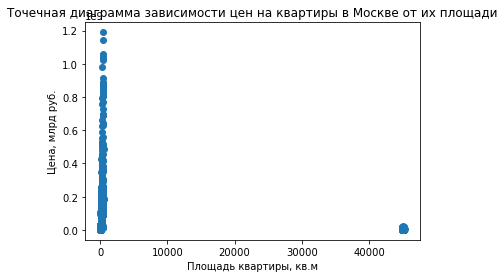

In [24]:
plt.scatter(our_df['area'], our_df['price'],)
plt.xlabel("Площадь квартиры, кв.м")
plt.ylabel("Цена, млрд руб.")
plt.title('Точечная диаграмма зависимости цен на квартиры в Москве от их площади')
plt.show()

Видим выбросы, которые соответствуют каким-то неточностям в исходных данных. Удалим все квартиры, чья площадь, согласно таблице, больше 750 квадратных метров.

In [25]:
our_df[our_df['area'] > 750]

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap,district
0,2021-01-01,3350000,1,19,-1,44936.0,2.0,55.778026,37.540147,3,0,123007,2.724138,9.008036,9.410932,САО
3,2021-01-01,3000000,1,5,1,45090.0,2.0,55.740164,37.546994,4,0,121165,1.483595,8.247074,8.379456,ЗАО
10,2021-01-01,7275600,14,16,1,45067.0,-100.0,55.602353,37.733576,0,2,115583,16.799201,12.488724,20.932783,ЮАО
22,2021-01-01,5462520,8,33,-1,45096.0,5.0,55.804736,37.750898,2,2,107553,5.692561,14.413725,15.497119,ВАО
34,2021-01-01,7888000,12,14,1,44984.0,45113.0,55.745960,37.407277,2,2,121552,0.839513,23.774525,23.789343,ЗАО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38057,2021-02-15,6569640,8,22,-1,44952.0,-100.0,55.863838,37.535296,3,2,127486,12.260842,9.547151,15.539510,САО
38081,2021-02-15,5442600,4,25,-1,44985.0,-100.0,55.890581,37.581505,3,2,127576,15.232955,4.411721,15.858947,СВАО
38168,2021-02-15,3650000,1,5,-1,44998.0,-100.0,55.763207,37.565022,4,0,123022,1.077219,6.243590,6.335836,ЦАО
38183,2021-02-15,8045786,19,23,-1,45015.0,-100.0,55.725088,37.748538,3,2,109428,3.159120,14.151469,14.499797,ЮАО


In [26]:
our_df1 = our_df.loc[our_df['area'] < 750]
our_df1

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap,district
1,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226,9.051312,1.797695,9.228107,СВАО
2,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020,1.427305,10.187288,10.286790,ЮВАО
4,2021-01-01,25173570,19,22,2,90.5,0.0,55.740356,37.522747,0,2,121170,1.462257,10.941772,11.039047,ЗАО
5,2021-01-01,10503090,17,31,1,42.3,45028.0,55.805465,37.714470,3,2,107392,5.773534,10.365282,11.864770,ВАО
6,2021-01-01,6418000,21,32,-1,20.0,5.0,55.805465,37.714470,3,2,107392,5.773534,10.365282,11.864770,ВАО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38202,2021-02-15,10400000,4,9,1,35.0,44967.0,55.732986,37.425405,0,0,121351,2.281376,21.759872,21.879139,ЗАО
38203,2021-02-15,19800000,3,9,2,44.2,0.0,55.749118,37.567938,0,0,121248,0.488516,5.919443,5.939567,ЗАО
38204,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620,11.903510,23.429051,26.279536,ЗАО
38205,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427,8.046497,2.558769,8.443543,СВАО


Мы видим, что в данных еще выбросы в колонке с площадью кухни: некоторые значения там больше 40 тыс. кв.м., чего не может быть в реальности. Проверим, для скольких наблюдений площадь кухни превышает общую площадь квартиры. 

In [27]:
our_df1[our_df1['kitchen_area'] > our_df1['area']]

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap,district
1,2021-01-01,22112640,8,29,3,69.8,45088.0,55.834958,37.637378,0,2,129226,9.051312,1.797695,9.228107,СВАО
2,2021-01-01,7400000,9,9,1,32.3,44962.0,55.766357,37.712868,3,0,111020,1.427305,10.187288,10.286790,ЮВАО
5,2021-01-01,10503090,17,31,1,42.3,45028.0,55.805465,37.714470,3,2,107392,5.773534,10.365282,11.864770,ВАО
8,2021-01-01,17140000,2,9,3,61.4,45052.0,55.740456,37.567350,4,0,121059,1.451199,5.984835,6.158265,ЦАО
13,2021-01-01,8150000,3,5,2,44.7,45112.0,55.657598,37.706331,2,0,109235,10.659667,9.460844,14.252581,ЮВАО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38199,2021-02-15,10300000,4,5,2,46.1,45082.0,55.673544,37.557259,0,0,117335,8.887455,7.106296,11.379205,ЮЗАО
38202,2021-02-15,10400000,4,9,1,35.0,44967.0,55.732986,37.425405,0,0,121351,2.281376,21.759872,21.879139,ЗАО
38204,2021-02-15,7900000,4,14,1,38.0,45054.0,55.646405,37.410386,0,0,119620,11.903510,23.429051,26.279536,ЗАО
38205,2021-02-15,11500000,10,17,1,39.0,44992.0,55.825917,37.598178,2,0,127427,8.046497,2.558769,8.443543,СВАО


In [28]:
our_df2 = our_df1.loc[our_df1['area'] > our_df1['kitchen_area']]
our_df2

,date,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,diff_lat,diff_lon,gap,district
4,2021-01-01,25173570,19,22,2,90.5,0.0,55.740356,37.522747,0,2,121170,1.462257,10.941772,11.039047,ЗАО
6,2021-01-01,6418000,21,32,-1,20.0,5.0,55.805465,37.714470,3,2,107392,5.773534,10.365282,11.864770,ВАО
7,2021-01-01,21000000,4,18,4,92.9,12.0,55.703682,37.774426,2,0,109443,5.538072,17.028528,17.906452,ЮВАО
9,2021-01-01,11750000,17,17,3,76.6,11.0,55.669064,37.767284,2,0,109559,9.385339,16.234803,18.752424,ЮВАО
11,2021-01-01,11000000,2,9,3,55.1,6.0,55.807415,37.768148,0,0,105122,5.990280,16.330823,17.394805,ВАО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38196,2021-02-15,15500000,7,17,2,58.0,10.0,55.748468,37.420689,2,0,121609,0.560787,22.283984,22.291040,ЗАО
38198,2021-02-15,13500000,1,5,1,47.2,10.0,55.784101,37.655976,0,0,107140,3.399326,3.864648,5.146934,ЦАО
38200,2021-02-15,18500000,10,14,2,53.0,9.0,55.824705,37.651949,4,0,129301,7.911780,3.417030,8.618141,СВАО
38201,2021-02-15,8100000,7,9,2,44.8,6.0,55.704551,37.793004,2,0,109378,5.441496,19.093180,19.853448,ЮВАО


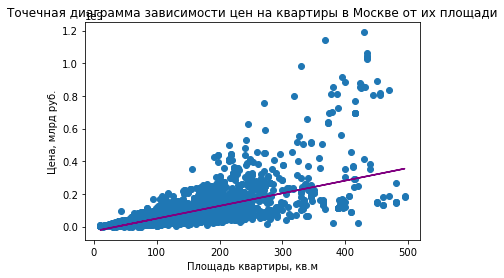

In [29]:
plt.scatter(our_df2['area'], our_df2['price'])
plt.xlabel("Площадь квартиры, кв.м")
plt.ylabel("Цена, млрд руб.")
z = np.polyfit(our_df2['area'], our_df2['price'], 1)
p = np.poly1d(z)
plt.plot(our_df2['area'], p(our_df2['area']), color='purple')
plt.title('Точечная диаграмма зависимости цен на квартиры в Москве от их площади')
plt.show()

Видно положительный тренд: при увеличении площади квартиры цена на нее растет.

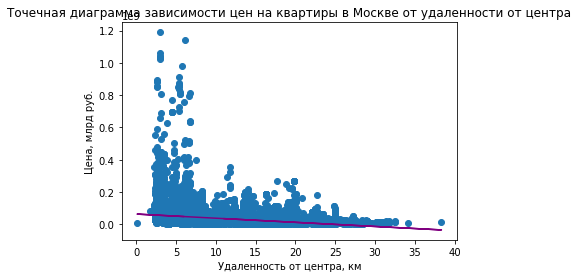

In [32]:
plt.scatter(our_df2['gap'], our_df2['price'])
plt.xlabel("Удаленность от центра, км")
plt.ylabel("Цена, млрд руб.")
z = np.polyfit(our_df2['gap'], our_df2['price'], 1)
p = np.poly1d(z)
plt.plot(our_df2['gap'], p(our_df2['gap']), color='purple')
plt.title('Точечная диаграмма зависимости цен на квартиры в Москве от удаленности от центра')
plt.show()

Линия тренда имеет отрицательный наклон: чем дальше от центра, тем дешевле квартира.

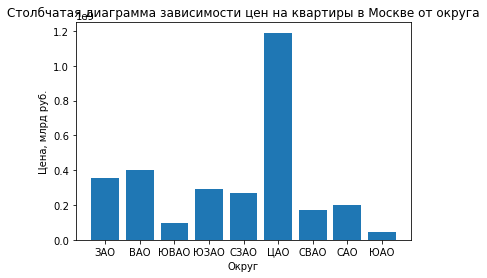

In [30]:
plt.bar(our_df2['district'], our_df2['price'])
plt.xlabel("Округ")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от округа')
plt.show()

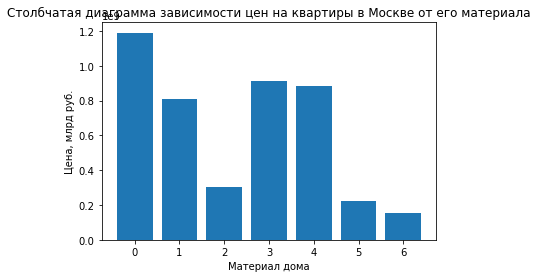

In [34]:
plt.bar(our_df2['building_type'], our_df2['price'])
plt.xlabel("Материал дома")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от его материала')
plt.show()

Самые дорогие квартиры находятся в домах нулевого типа, который соответствует неизвестному материалу дома. Кроме того, первый тип тоже неидентифицируемый. 

Так как у нас есть 3 категориальные переменные, то необходимо будет сделать OHE, следовательно, будет очень много дополнительных колонок, что в дальнейшем может помешать машинному обучению. Информация о материале дома может быть частично заложена в другие переменные, например, в число этажей. Тем более, результаты, полученные с использованием данной переменной, будет трудно интерпретировать ("неизвестный" материал - это что?). Поэтому мы решили удалить эту переменную.

In [35]:
our_df2.drop('building_type', axis=1, inplace=True)

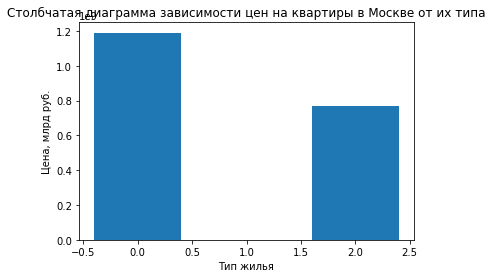

In [36]:
plt.bar(our_df2['object_type'], our_df2['price'])
plt.xlabel("Тип жилья")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от их типа')
plt.show()

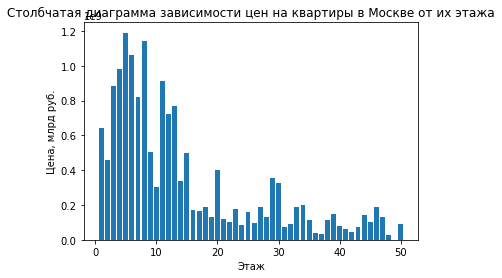

In [37]:
plt.bar(our_df2['floor'], our_df2['price'])
plt.xlabel("Этаж")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от их этажа')
plt.show()

Видим, что есть тенденция к уменьшению стоимости квартиры с увеличением этажа, на котором она расположена. Предположительно, наиболее дорогие квартиры расположены в центре Москвы (сталинки). 

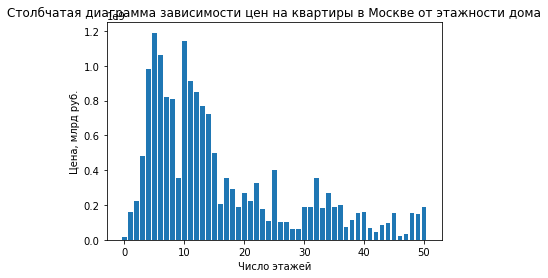

In [38]:
plt.bar(our_df2['n_floors'], our_df2['price'])
plt.xlabel("Число этажей")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от этажности дома')
plt.show()

Наиболее дорогие квартиры расположены в малоэтажных домах. Этому можно дать несколько объяснений: во-первых, малоэтажные дома часто расположены в центре города, часто это сталинки, которые ценятся на рынке недвижимости. Кроме того, в высотках есть проблемы с паркингом, а также с инфраструктурой рядом с домом, так как плотность населения очень большая. Чтобы этого избежать, многие выбирают малоэтажные дома. (Да и в целом, многие ценят "уединение" и не хотят жить среди очень большого числа людей)

Построим корреляционную матрицу, чтобы посмотреть, какие зависимости между переменными можно проверить в части о гипотезах.

In [40]:
our_df2.corr().style.background_gradient(cmap='RdYlGn')

,price,floor,n_floors,rooms,area,kitchen_area,geo_lat,geo_lon,object_type,postal_code,diff_lat,diff_lon,gap
price,1.000000,0.033688,-0.038913,0.435455,0.739559,0.058332,-0.041319,-0.108308,-0.043831,0.067642,-0.227658,-0.173723,-0.294579
floor,0.033688,1.000000,0.636987,0.105526,0.134191,-0.057355,0.036890,-0.130879,0.253941,0.077641,-0.037783,0.051941,0.026859
n_floors,-0.038913,0.636987,1.000000,0.039524,0.090736,-0.114465,0.067767,-0.181404,0.361412,0.103689,-0.053845,0.079994,0.045184
rooms,0.435455,0.105526,0.039524,1.000000,0.743528,0.151343,-0.016574,-0.142127,-0.040611,0.084837,-0.195914,-0.057329,-0.163876
area,0.739559,0.134191,0.090736,0.743528,1.000000,0.076408,-0.020269,-0.197648,0.001725,0.124063,-0.248437,-0.113128,-0.247561
kitchen_area,0.058332,-0.057355,-0.114465,0.151343,0.076408,1.000000,-0.075199,0.014533,-0.348731,-0.044281,-0.018965,0.010360,-0.003622
geo_lat,-0.041319,0.036890,0.067767,-0.016574,-0.020269,-0.075199,1.000000,-0.051696,0.094396,0.468719,0.023718,-0.228894,-0.177424
geo_lon,-0.108308,-0.130879,-0.181404,-0.142127,-0.197648,0.014533,-0.051696,1.000000,-0.060973,-0.619069,0.098113,-0.156003,-0.095581
object_type,-0.043831,0.253941,0.361412,-0.040611,0.001725,-0.348731,0.094396,-0.060973,1.000000,0.059006,-0.012476,-0.003686,-0.017153
postal_code,0.067642,0.077641,0.103689,0.084837,0.124063,-0.044281,0.468719,-0.619069,0.059006,1.000000,0.136152,-0.335611,-0.206337


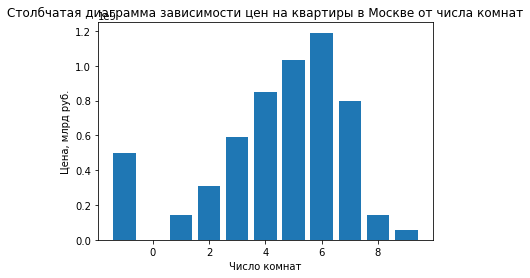

In [41]:
plt.bar(our_df2['rooms'], our_df2['price'])
plt.xlabel("Число комнат")
plt.ylabel("Цена, млрд руб.")
plt.title('Столбчатая диаграмма зависимости цен на квартиры в Москве от числа комнат')
plt.show()

На этом этапе мы предположжили, что студии стоят дороже, чем однокомнатные и двухкомнатные квартиры.